In [1]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.framework import ops
##sns.set()


In [2]:
df = pd.read_csv('./dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
from collections import deque
import random
tf.compat.v1.disable_eager_execution()

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\User\AppData\Local\Temp\ipykernel_3884\1819718061.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\User\AppData\Local\Temp\ipykernel_3884\1819718061.py:27: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: 112.205319.3, cost: 0.957716, total money: 10112.205319
epoch: 20, total rewards: 257.185238.3, cost: 0.311062, total money: 10257.185238
epoch: 30, total rewards: 284.115354.3, cost: 0.188648, total money: 10284.115354
epoch: 40, total rewards: 270.525327.3, cost: 0.144951, total money: 10270.525327
epoch: 50, total rewards: 315.095275.3, cost: 0.120252, total money: 10315.095275
epoch: 60, total rewards: 329.685363.3, cost: 0.106739, total money: 10329.685363
epoch: 70, total rewards: 351.405333.3, cost: 0.095744, total money: 10351.405333
epoch: 80, total rewards: 202.595337.3, cost: 0.088827, total money: 10202.595337
epoch: 90, total rewards: 210.065248.3, cost: 0.079999, total money: 10210.065248
epoch: 100, total rewards: 320.965211.3, cost: 0.073705, total money: 10320.965211
epoch: 110, total rewards: 219.425234.3, cost: 0.782459, total money: 10219.425234
epoch: 120, total rewards: 148.015201.3, cost: 0.060630, total money: 10148.015201
epoch: 130, t

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 762.020020, total balance 9237.979980
day 3, sell 1 unit at price 782.520020, investment 2.690218 %, total balance 10020.500000,
day 6: buy 1 unit at price 762.559998, total balance 9257.940002
day 7: buy 1 unit at price 754.020020, total balance 8503.919982
day 10, sell 1 unit at price 764.479980, investment 0.251781 %, total balance 9268.399962,
day 12, sell 1 unit at price 760.539978, investment 0.864693 %, total balance 10028.939940,
day 15: buy 1 unit at price 760.989990, total balance 9267.949950
day 16, sell 1 unit at price 761.679993, investment 0.090672 %, total balance 10029.629943,
day 26: buy 1 unit at price 789.289978, total balance 9240.339965
day 29, sell 1 unit at price 797.070007, investment 0.985700 %, total balance 10037.409972,
day 35: buy 1 unit at price 791.260010, total balance 9246.149962
day 37: buy 1 unit at price 791.549988, total balance 8454.599974
day 38, sell 1 unit at price 785.049988, investment -0.784827 %, total balance 9239

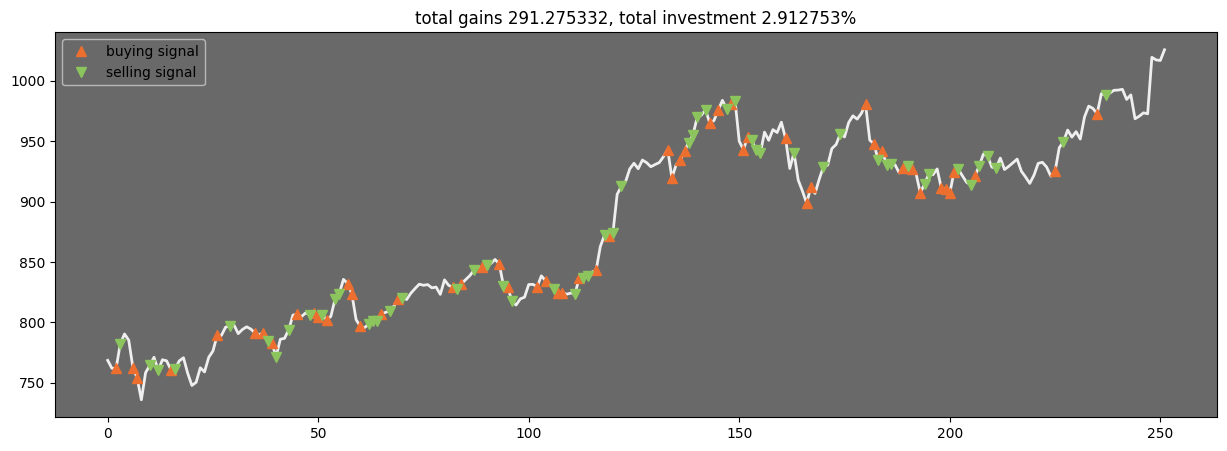

In [10]:
fig = plt.figure(figsize = (15,5))
plt.rcParams['axes.facecolor'] = 'dimgrey'

plt.plot(close, color='#EFEFEF', lw=2.)
plt.plot(close, '^', markersize=7, color='#ED6F2F', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=7, color='#8CC55D', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()